In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.gnn as gnn
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
num_nodes, node_dim = 10, 5

dataset = random_graph_dataset.RandomGraphDataset(
    num_nodes, node_dim, num_items=6400,
    graph_type="diverse_cliques", clique_sizes=[3, 4, 5, 6], noise_level=0
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0  # TODO: allow multi-processing
)

### Create the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliZeroDiffuser(100, 10, (1,))  # Make input shape just 1

t_limit = 1000

model = gnn.GraphLinkPredictor(
    node_dim, t_limit,
    num_gnn_layers=4,
    virtual_node=False
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models/misc"

import model.train_model as train_model  # Import this AFTER setting environment

### Show the forward-diffusion process

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


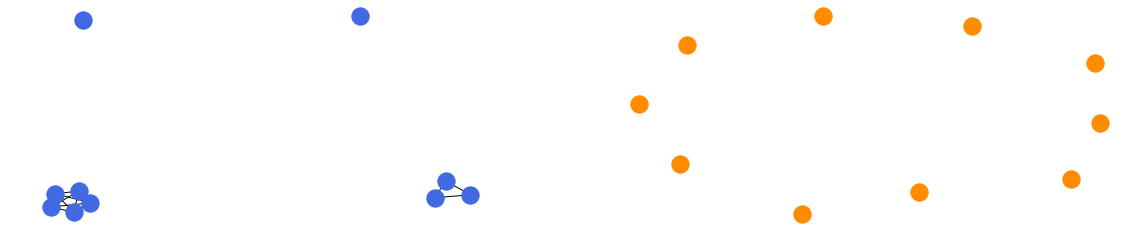

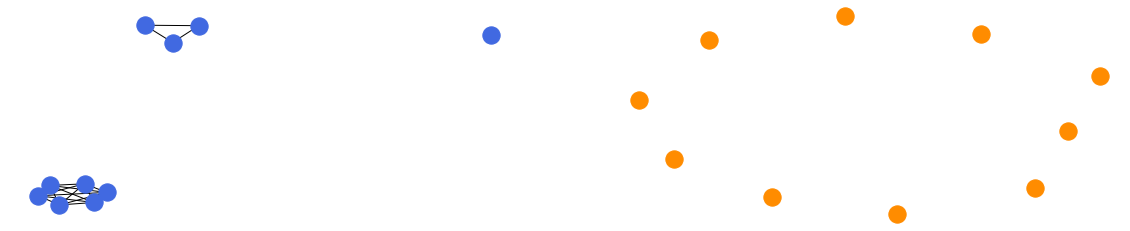

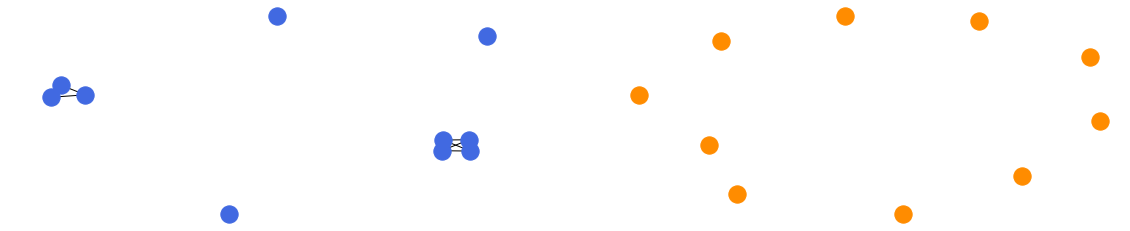

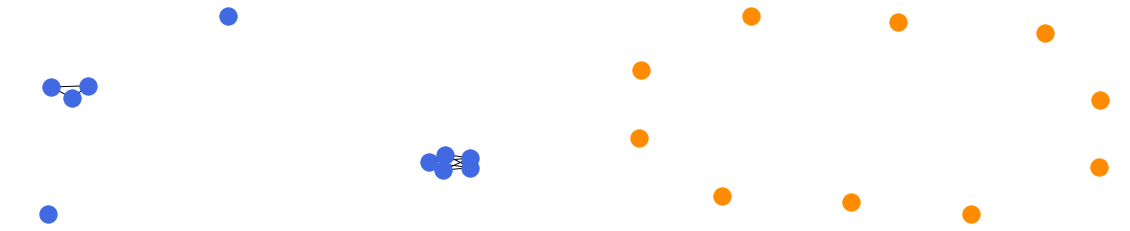

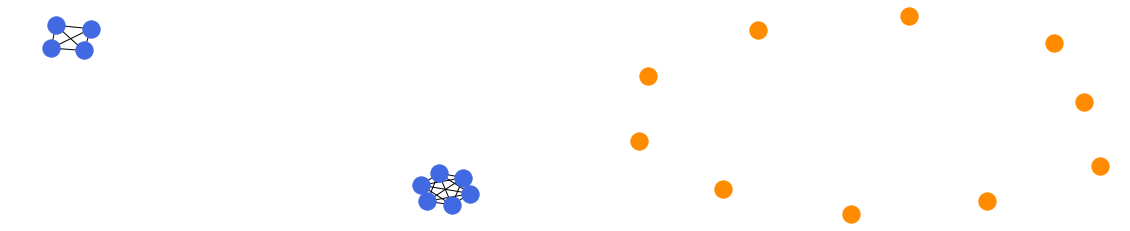

In [5]:
# Check the NetworkX graphs in a batch directly from the data loader, and
# after adding noise for a long time
data = next(iter(data_loader))

graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)

e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = diffuser.forward(e0[:, None], t_e, return_posterior=False)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)

graphs_t = graph_conversions.split_pyg_data_to_nx_graphs(data)

for i in np.random.choice(len(graphs_0), replace=False, size=min(5, len(graphs_0))):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    nx.draw(graphs_0[i], ax=ax[0], node_color="royalblue")
    nx.draw(graphs_t[i], ax=ax[1], node_color="darkorange")
    plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

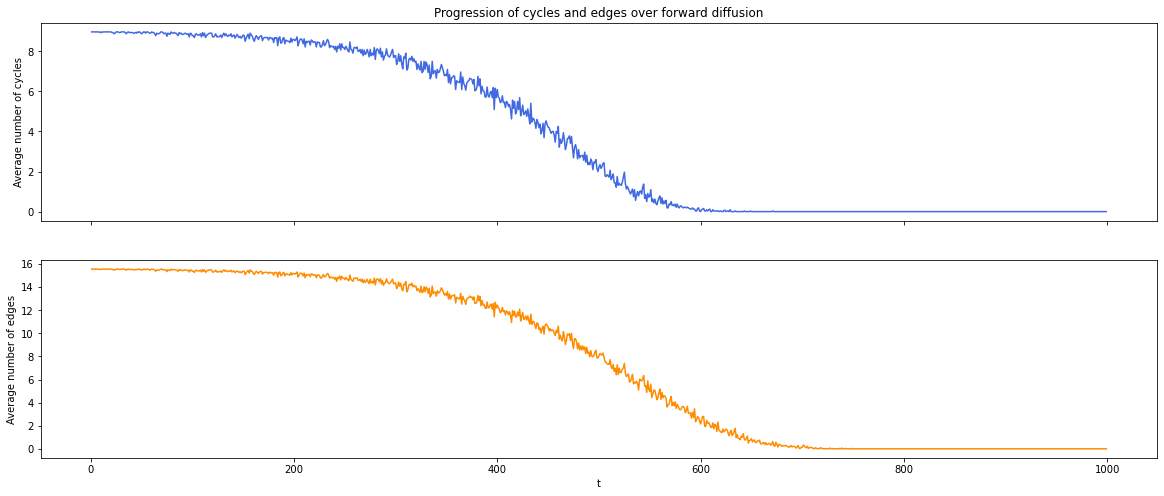

In [6]:
# Check progression of the number of cycles and edges
t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = diffuser.forward(e0[None], t_tens, return_posterior=False)[0]  # Do the noising on 1 x E tensors
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

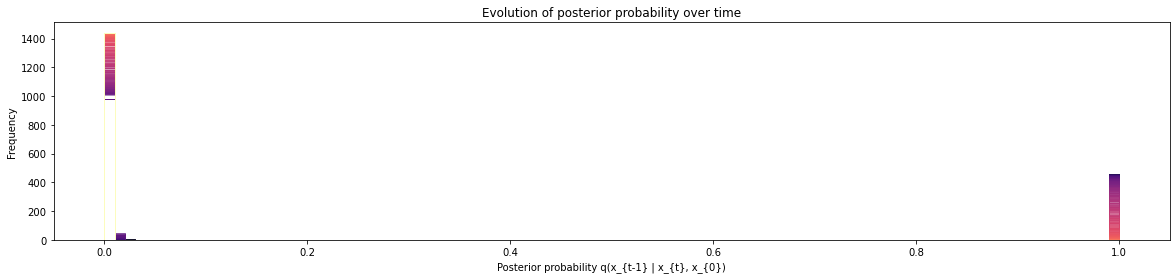

In [7]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et, p = diffuser.forward(e0[None], t_tens)  # Do the noising on 1 x E tensors
    et, p = et[0], p[0]
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 4))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

### Train the model

In [8]:
train_model.train_ex.run(
    "train_graph_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "num_epochs": 10,
        "learning_rate": 0.01,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_graph_model'
INFO - train - Started run with ID "36"
Loss: 0.0274: 100%|████████████████████████████████████████| 200/200 [00:09<00:00, 20.24it/s]


Epoch 8 average Loss: 0.0228


Loss: 0.0271: 100%|████████████████████████████████████████| 200/200 [00:09<00:00, 20.20it/s]


Epoch 9 average Loss: 0.0238


Loss: 0.0102: 100%|████████████████████████████████████████| 200/200 [00:09<00:00, 20.36it/s]
INFO - train - Completed after 0:01:40


Epoch 10 average Loss: 0.0233


### Show generated graphs

In [9]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

# Sample from the prior
data = next(iter(data_loader))
edges = graph_conversions.pyg_data_to_edge_vector(data)
sampled_edges = diffuser.sample_prior(
    edges.shape[0], # Samples will be E x 1
    torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
)[:, 0]  # Shape: E
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)

samples, times = generate.generate_graph_samples(
    model, diffuser, data, t_limit=t_limit, return_all_times=True
)
times = times.cpu().numpy()
# Split samples into individual graphs
graph_samples = [
    graph_conversions.split_pyg_data_to_nx_graphs(sample)
    for sample in samples
]

Sampling some reverse trajectories


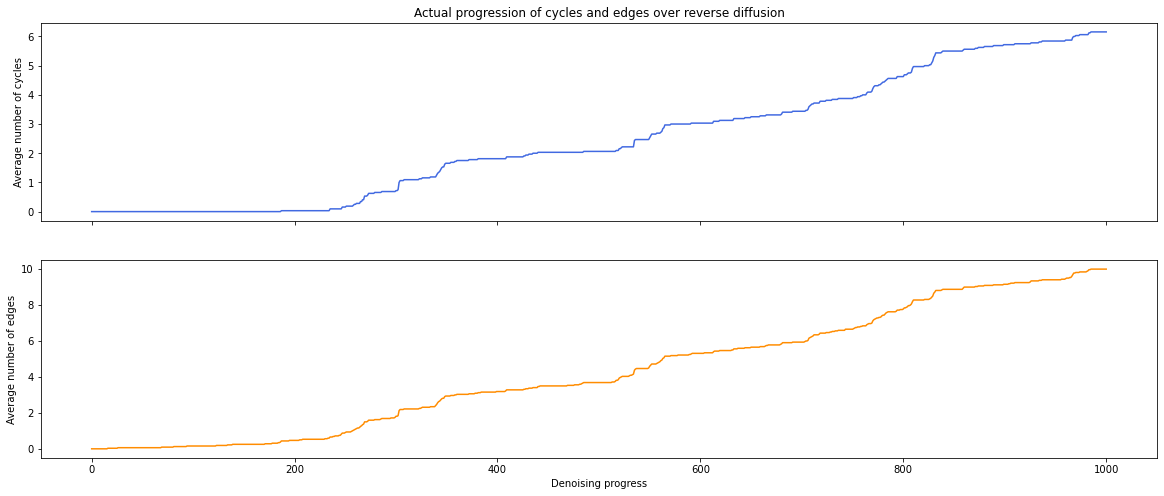

In [10]:
# Check progression of the number of cycles and edges
num_cycles = np.empty((len(graph_samples), len(graph_samples[0])))
num_edges = np.empty((len(graph_samples), len(graph_samples[0])))
for i in range(len(graph_samples)):
    for j, g in enumerate(graph_samples[i]):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(np.arange(len(graph_samples)), np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(np.arange(len(graph_samples)), np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("Denoising progress")

ax[0].set_title("Actual progression of cycles and edges over reverse diffusion")
plt.show()

0


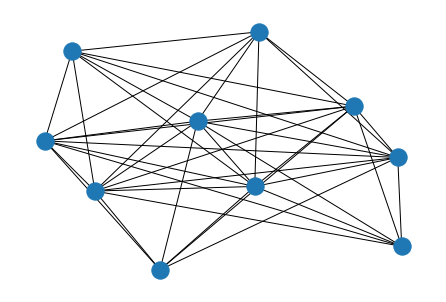

1


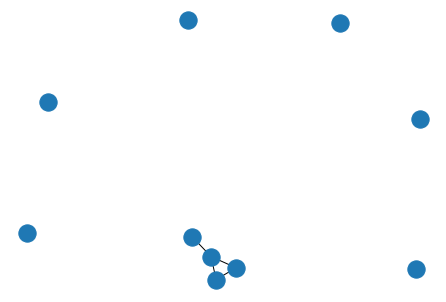

2


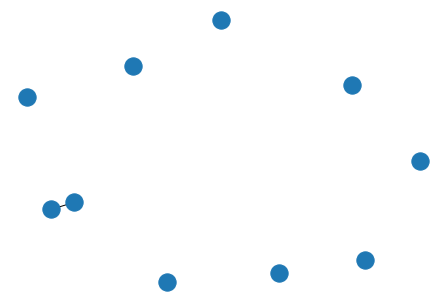

3


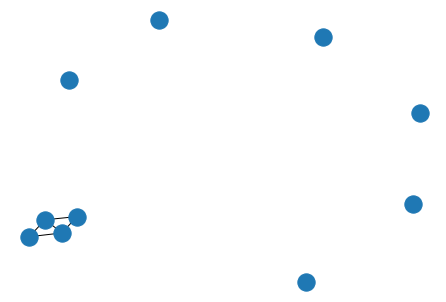

4


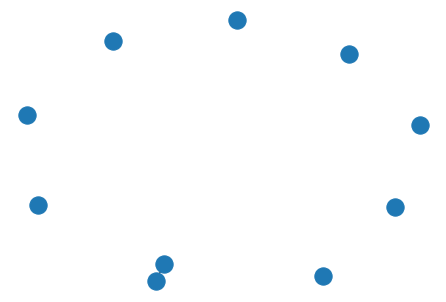

5


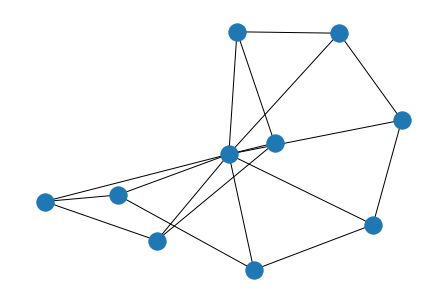

6


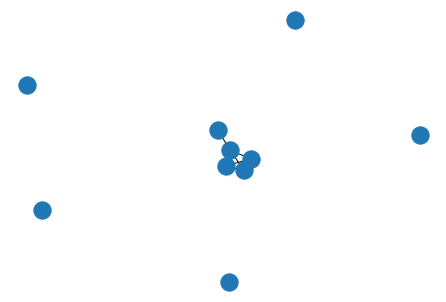

7


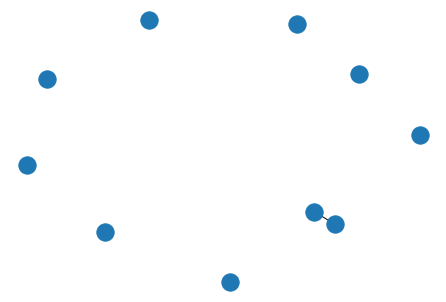

8


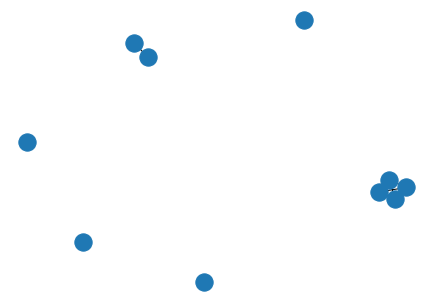

9


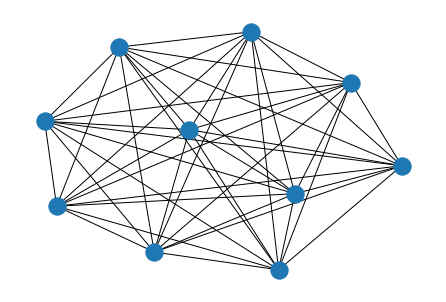

10


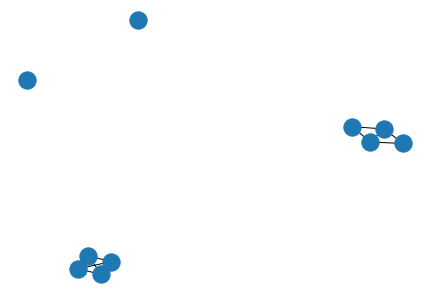

11


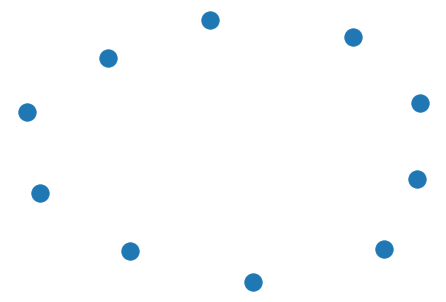

12


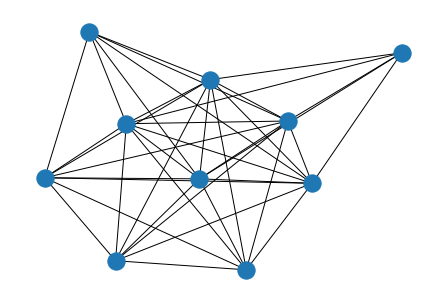

13


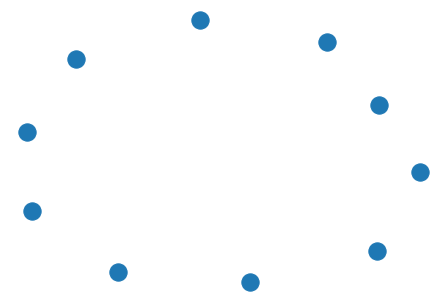

14


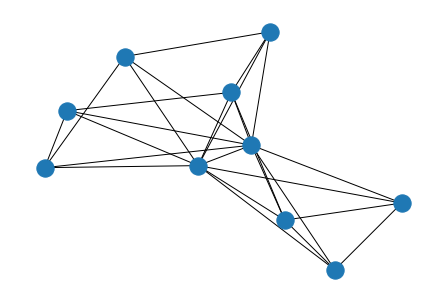

15


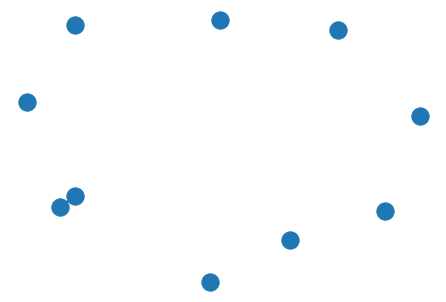

16


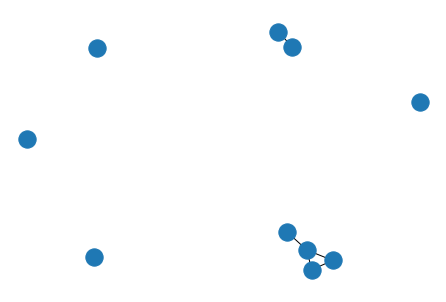

17


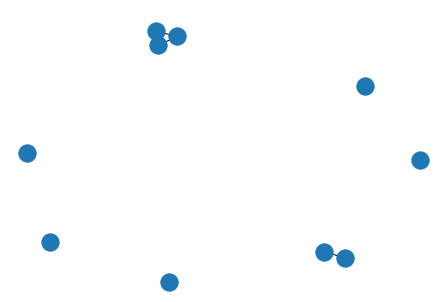

18


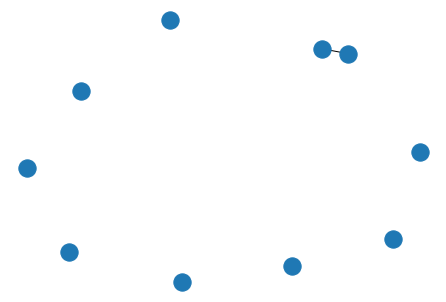

19


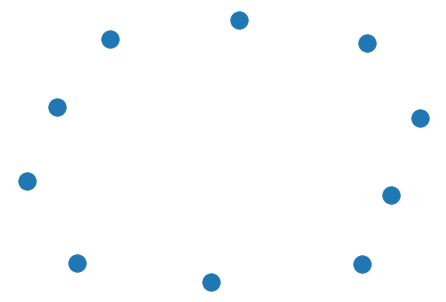

20


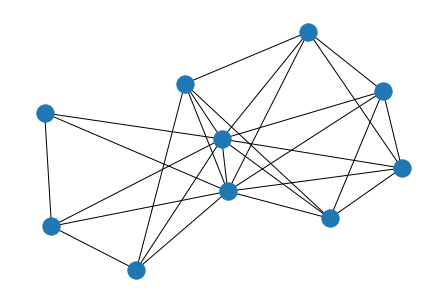

21


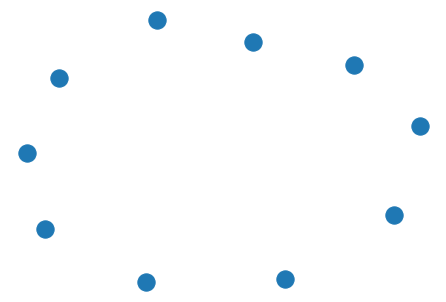

22


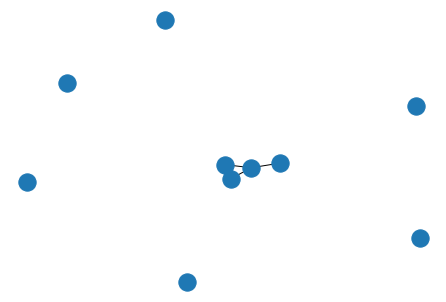

23


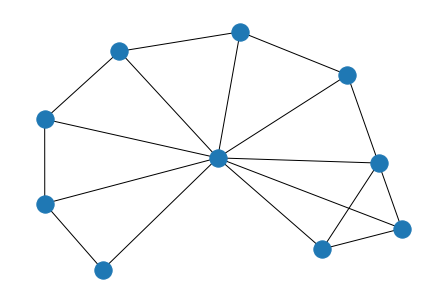

24


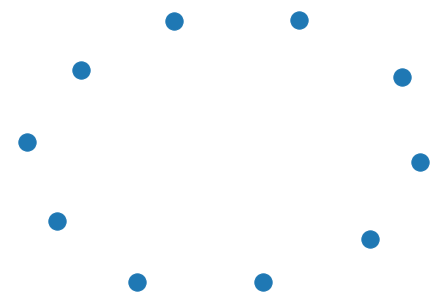

25


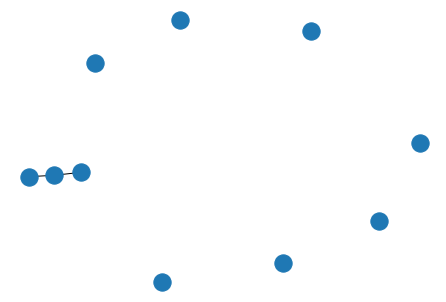

26


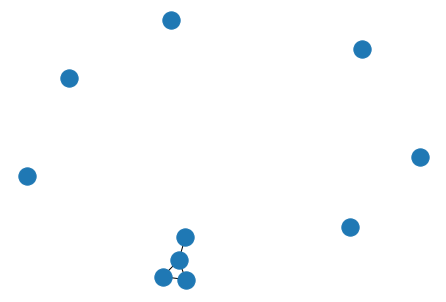

27


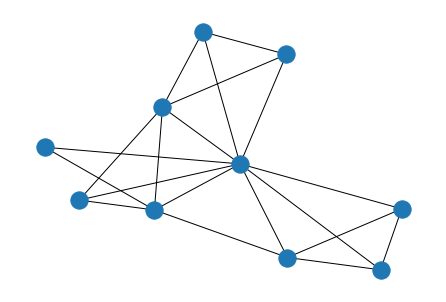

28


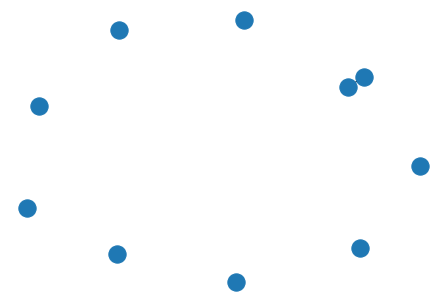

29


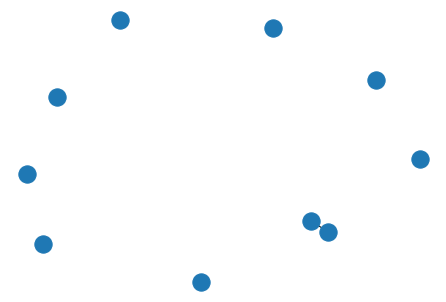

30


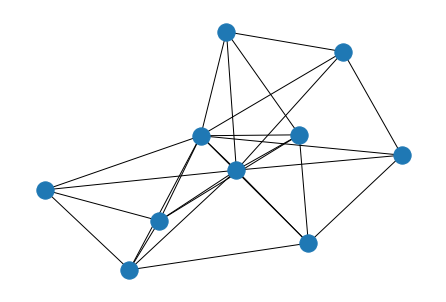

31


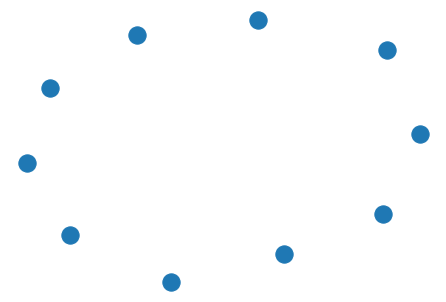

In [11]:
# Plot some randomly generated graphs
for i in range(len(graph_samples[-1])):
    print(i)
    nx.draw(graph_samples[-1][i])
    plt.show()

1000


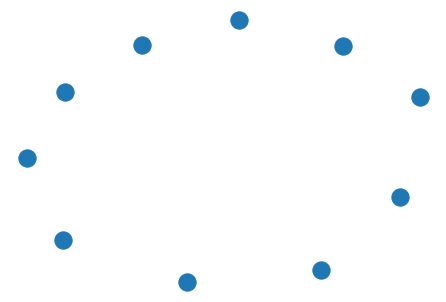

950


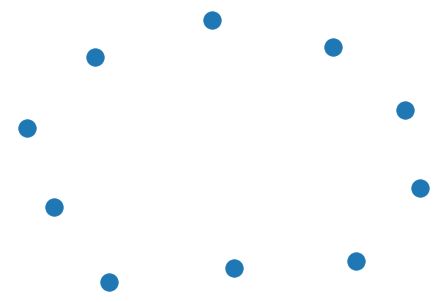

900


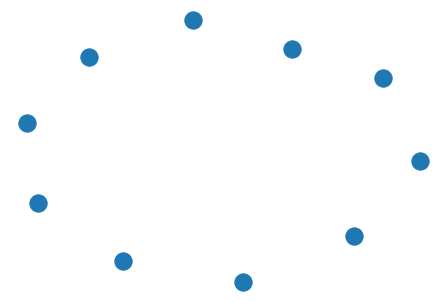

850


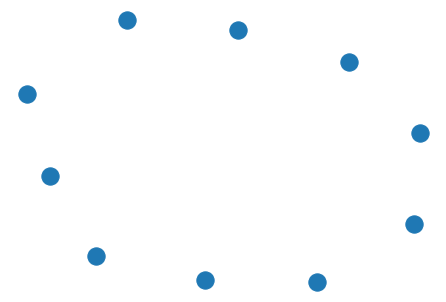

800


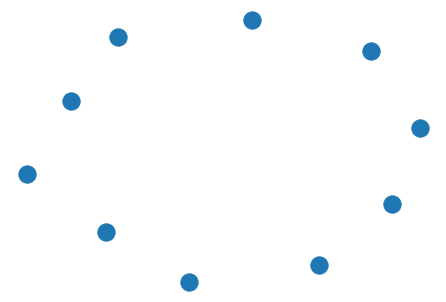

750


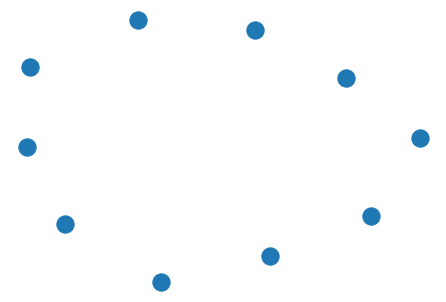

700


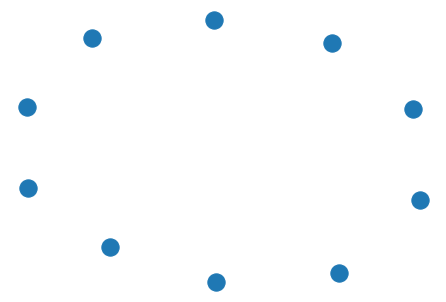

650


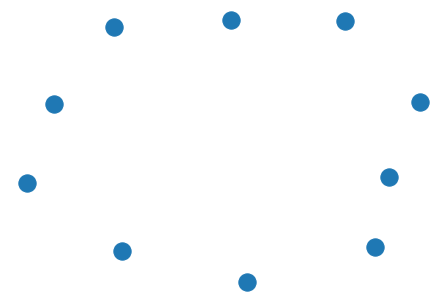

600


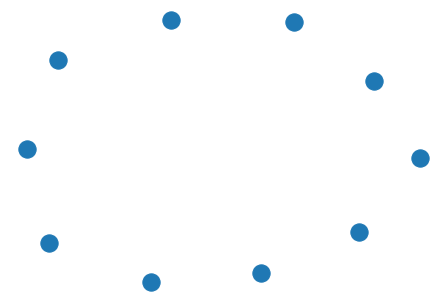

550


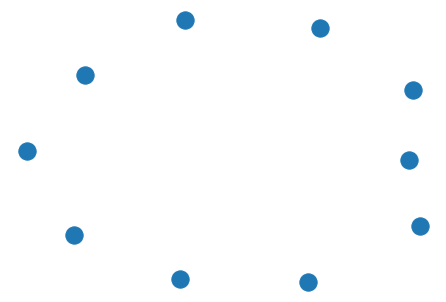

500


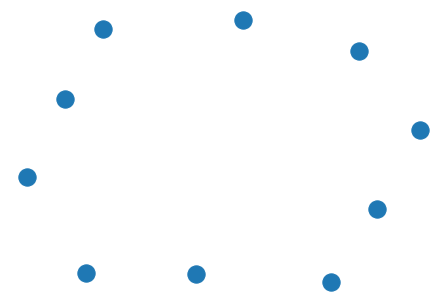

450


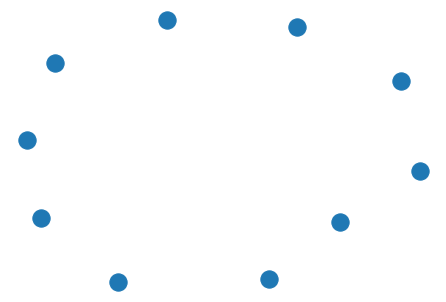

400


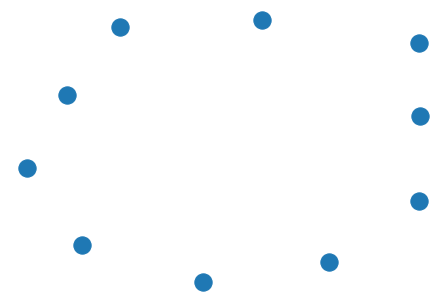

350


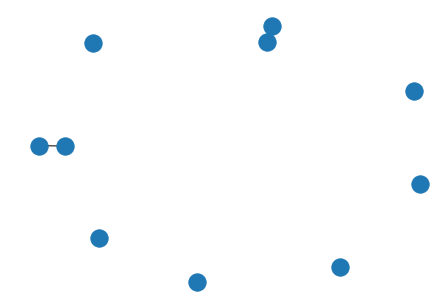

300


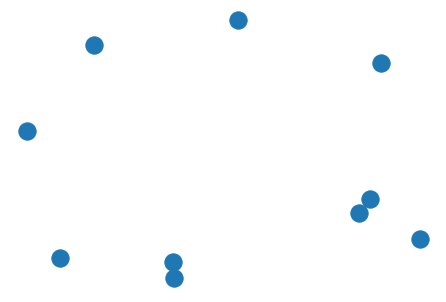

250


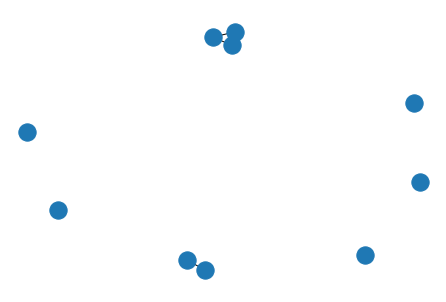

200


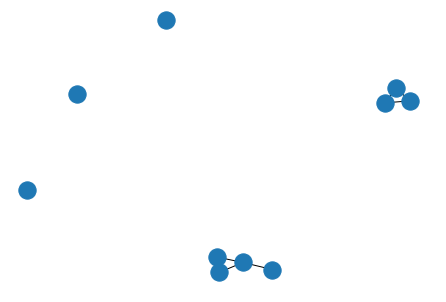

150


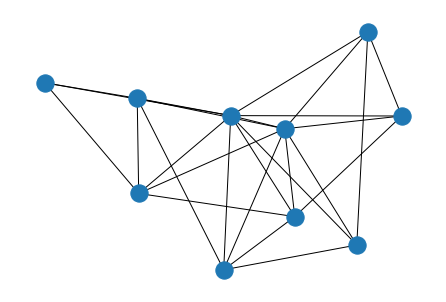

100


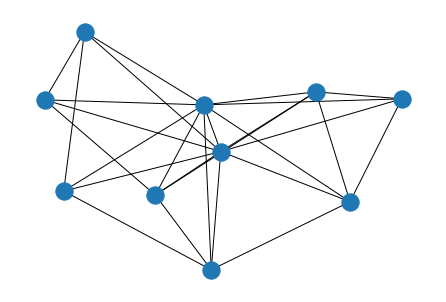

50


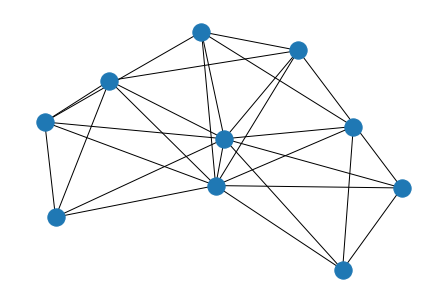

0


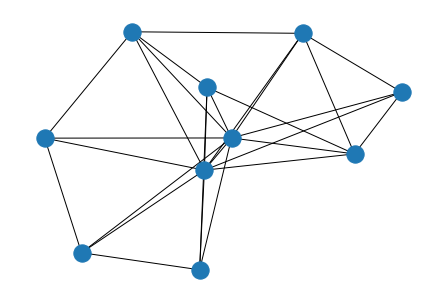

In [12]:
i = 30
num_to_show = 20
time_inds = np.arange(0, len(times), len(times) // num_to_show)
time_inds[-1] = len(times) - 1
for t_i in time_inds:
    print(times[t_i])
    nx.draw(graph_samples[t_i][i])
    plt.show()